In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter , lfilter
from scipy.fftpack import fft, fftfreq
%matplotlib inline

from scipy import signal

In [2]:
'''  MODEL PARAMETERS '''

Cm = 100*pF                    # membrane capacitance
g_leak =10*nS                  # leak conductance
E_rest = -65*mvolt             # membrane rest potential
V_thresh = -52*mvolt           # membrane threshold potential
V_reset = -67*mvolt            # membrane reset potential 
tau_m = 10*ms                  # membrane time constant
tau_r = 1*ms                   # absolute refractory period

E_i  = -75*mvolt               # inhib. reversal potential
E_e  =  0*mvolt                # excit. reversal potential

tau_l = 1*ms                   # time delay 
tau_r_e  = 0.5*ms
tau_d_e  = 2*ms
tau_r_i  = 0.45*ms
#tau_d_i  = 1.2*ms

g_peak_e = 1*nS
#g_peak_i = 5*nS


N_inhib = 200      # number of inhibitory inter neurons in the network
N_excit = 800      # each inter neuron gets input from 800 excit. neurons.

In [3]:
def heaviside(t , t0):
    if t >= t0:
        return 1
    else:
        return 0  

In [4]:
def do_simulation(sim_dur, inp_freq, tau_d_i=1.2*ms, g_peak_i=5*nS):
    defaultclock.dt = 0.05*ms             # choose a particular time step
    timestep = 0.05*ms
    input_rate = (inp_freq/N_excit)*Hz       # total input to each neuron is 5 KHz
    alpha = 20 /ms

    ''' ----------  NEURON EQUATIONS ------------- '''

    eqs_model = '''
    dv/dt = (g_leak*(E_rest - v) + I_syn )/Cm : volt
    I_syn = I_ampa_exc + I_rec : amp
    I_ampa_exc = g_peak_e*(E_e - v)*s_ampa_tot : amp
    I_rec = g_peak_i*(E_i -v)*s_rec_tot : amp
    s_ampa_tot : 1
    s_rec_tot  : 1
    '''

    eqs_ampa = '''
    s_ampa_tot_post = w * s_ampa : 1 (summed)
    ds_ampa / dt = - s_ampa / tau_d_e + alpha * x * (1 - s_ampa) : 1 (clock-driven)
    dx / dt = - x / tau_r_e : 1 (clock-driven)
    w : 1
    '''
    eqs_pre_ampa = '''
    x += 1
    '''
    eqs_rec = '''
    s_rec_tot_post = w * s_rec : 1 (summed)
    ds_rec / dt = - s_rec / tau_d_i + alpha * y * (1 - s_rec) : 1 (clock-driven)
    dy / dt = - y / tau_r_i : 1 (clock-driven)
    w : 1
    '''
    eqs_pre_rec = '''
    y += 1
    '''
    #clip(gi, 0, g_peak_i)
    P = PoissonGroup(8400, rates=input_rate)

    G = NeuronGroup(N_inhib, eqs_model, threshold='v> V_thresh', reset='v = V_reset', method ='euler')

    # Excitatory Synapse Group
    S_excit = Synapses(P,G, model=eqs_ampa , on_pre= eqs_pre_ampa , delay = tau_l , method = 'euler')
    S_excit.connect(p=0.095)
    S_excit.w = 1.0
    # Inhibitory, Recurrent Synapse Group

    S_inhib = Synapses(G,G,model=eqs_rec , on_pre= eqs_pre_rec , delay = tau_l , method = 'euler')
    S_inhib.connect(condition='i!=j', p=0.2)
    # set inhib weights to 1.0 as well
    S_inhib.w = 1.0
    # Spike, State Monitors

    State_Mon = StateMonitor(G, 'v',record=True)
    Spike_Mon = SpikeMonitor(G)
    Rate_Mon = PopulationRateMonitor(G)

    # initialise at rest 
    G.v = E_rest
    print('Before v = %s' % G.v[0])
    run(sim_dur)
    print('After v = %s' % G.v[0])
    
    return (State_Mon, Spike_Mon, Rate_Mon)

In [5]:
def freq_analysis(time_vec, signal):
    
    # sampling freq.
    fs = 1000/(time_vec[1] - time_vec[0]) 

    # FFT & get power spectral density
    signalFFT = fft(signal-np.mean(signal))
    signalPSD = np.abs(signalFFT) ** 2
    # only up to fs/2, don't need mirror
    half = signalPSD[0:int(len(signalPSD)/2)]

    # create frequency-vector
    f = np.arange(0, fs/2, fs/(2*len(half)))

    return (f, half)
    #''''''''''
    #
    # Is the are a under the FFT normalized???
    #
    #''''''''''

def mean_spike(Spike_Mon, sim_time):
    spike=np.zeros(200)
    for j in range(0,200): 
        spike[j]=sum((Spike_Mon.i==j)*1)/(sim_time)
    return spike

def FFTplot(freq, signalFFT, ax):
    ax.plot(freq, signalFFT)
    ax.set_xlabel("$f$ [Hz]")
    ax.set_xlim([0, 500])
    
def plot_time(t, s, ax):
    ax.plot(t, s)
    ax.set_xlabel('ms')
    ax.set_ylabel('Membrane Potential (V)')
    ax.set_title('Network Population Activity')
    
def plot_firing_raster(Spike_Mon, ax):
    ax.plot(Spike_Mon.t/ms, Spike_Mon.i , '.k')
    ax.set_xlabel('ms')
    ax.set_ylabel('Neuron Index')
    ax.set_title('Network Firing Raster Plot')

def plot_firing_dist(spike, ax):
    #ax.hist(Rate_Mon.rate/Hz , bins = 20)
    #ax.set_title('Firing Frequency Distribution')
    
    ax.hist(spike,bins=20)
    ax.set_xlabel('Mean individual spike rate')
    ax.set_ylabel('Number of neurons')
    
def plot_time_and_freq(time, signal, axT, axF):
    # plot network activity in time domain
    plot_time(time, signal, axT)
    # plot frequency-domain of network actvity
    f, sFFT = freq_analysis(time, signal)
    FFTplot(f, sFFT, axF)

def plot_all(time, signal, Rate_Mon, Spike_Mon, sim_dur):
    fig, axs = plt.subplots(2,2, figsize=(15,10))
    plot_time_and_freq(time, signal, axs[0, 0], axs[0, 1])
    plot_firing_raster(Spike_Mon, axs[1, 0])
    
    spike = mean_spike(Spike_Mon, sim_dur)
    plot_firing_dist(spike, axs[1, 1])

In [6]:
## 500 Hz
start_scope()
simulation_duration_05 = 100*ms
input_freqency_05 = 500

State_Mon_05, Spike_Mon_05, Rate_Mon_05 = do_simulation(simulation_duration_05, input_freqency_05)

T_05 = State_Mon_05.t[1000:]/ms
v_pop_05 = np.mean(State_Mon_05.v , axis = 0)[1000:]     # population level average

WARNING    c:\users\debap\appdata\local\programs\python\python37\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\debap\.cython\brian_extensions\_cython_magic_977491d6de0534ef6a3a4584a6640019.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]
WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Before v = -65. mV
After v = -57.3981587 mV


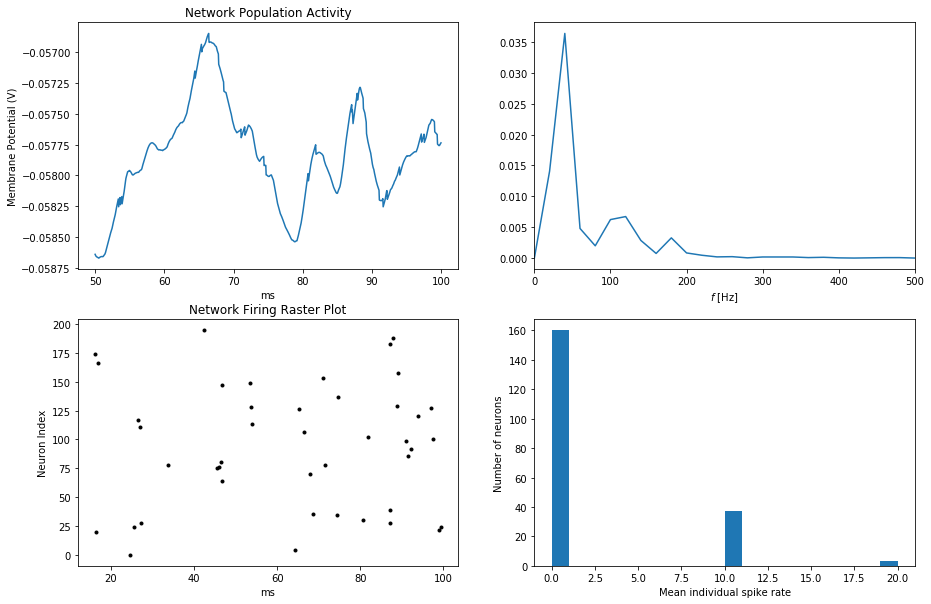

In [7]:
plot_all(T_05, v_pop_05, Rate_Mon_05, Spike_Mon_05, simulation_duration_05)

In [8]:
## 2000 Hz
start_scope()
simulation_duration_2k = 100*ms
input_freqency_2k = 2000

State_Mon_2k, Spike_Mon_2k, Rate_Mon_2k = do_simulation(simulation_duration_2k, input_freqency_2k)

T_2k = State_Mon_2k.t[1000:]/ms
v_pop_2k = np.mean(State_Mon_2k.v , axis = 0)[1000:]     # population level average

Before v = -65. mV
After v = -53.69794783 mV


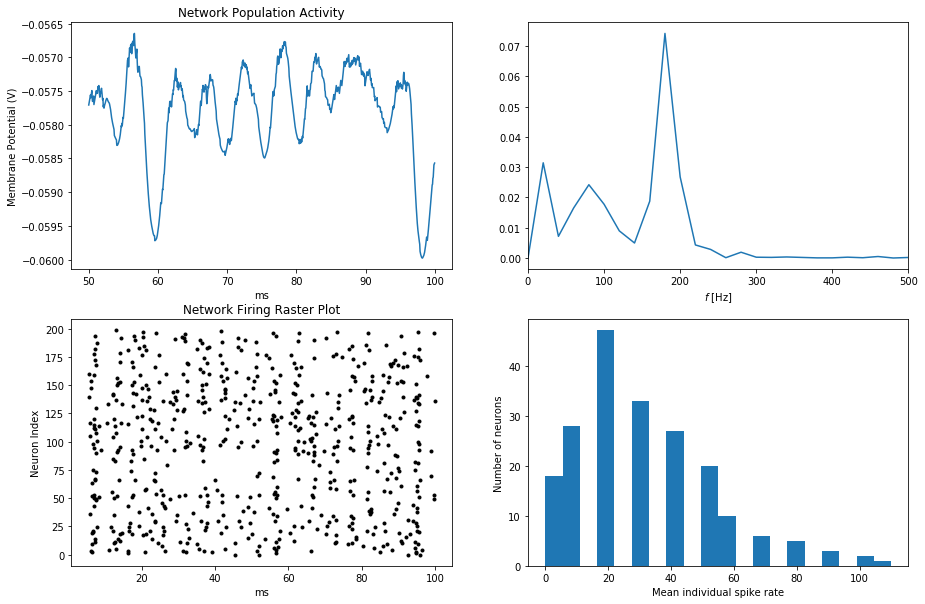

In [9]:
plot_all(T_2k, v_pop_2k, Rate_Mon_2k, Spike_Mon_2k, simulation_duration_2k)

In [10]:
## 5000 Hz
start_scope()
simulation_duration_5k = 100*ms
input_freqency_5k = 5000

State_Mon_5k, Spike_Mon_5k, Rate_Mon_5k = do_simulation(simulation_duration_5k, input_freqency_5k)

T_5k = State_Mon_5k.t[1000:]/ms
v_pop_5k = np.mean(State_Mon_5k.v , axis = 0)[1000:]     # population level average

Before v = -65. mV
After v = -60.88937342 mV


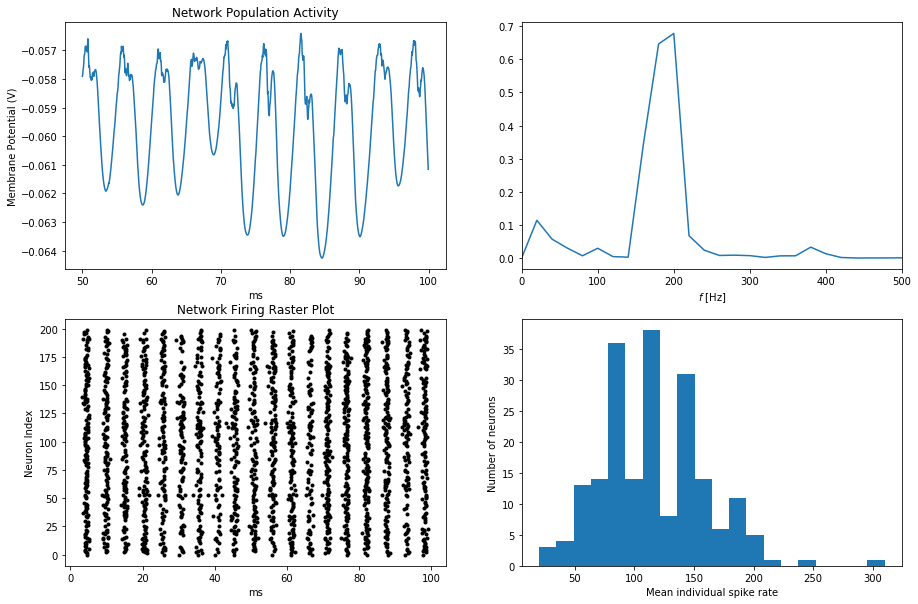

In [11]:
plot_all(T_5k, v_pop_5k, Rate_Mon_5k, Spike_Mon_5k, simulation_duration_5k)

Okay, so already at 5 KHz input frequency we do observe a ~ 200 Hz oscillation in the network.(Actually even at 2 kHz but there the raster plot is pretty uncoherent).

In [12]:
## 6000 Hz
start_scope()
simulation_duration_6k = 100*ms
input_freqency_6k = 6000

State_Mon_6k, Spike_Mon_6k, Rate_Mon_6k = do_simulation(simulation_duration_6k, input_freqency_6k)

T_6k = State_Mon_6k.t[1000:]/ms
v_pop_6k = np.mean(State_Mon_6k.v , axis = 0)[1000:]     # population level average

Before v = -65. mV
After v = -57.84492433 mV


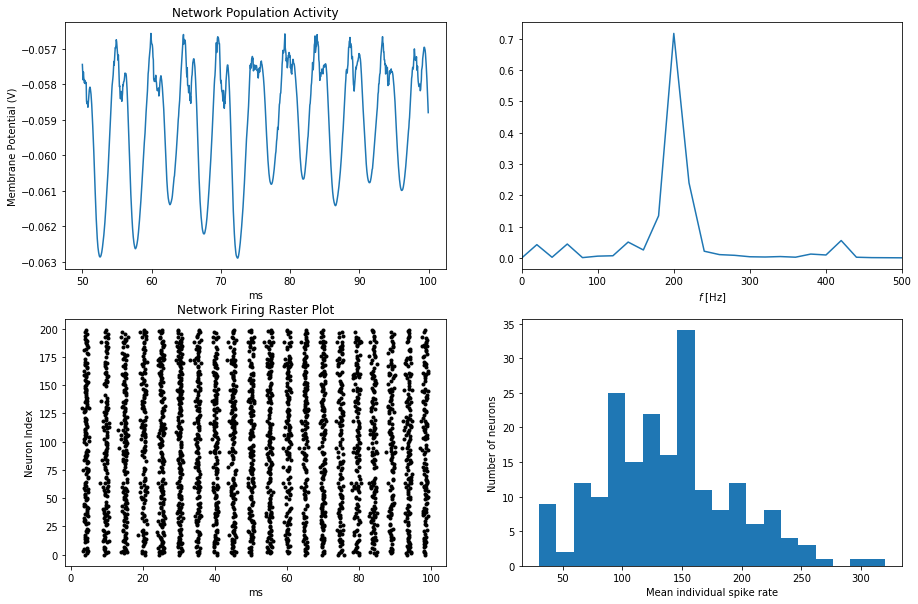

In [13]:
plot_all(T_6k, v_pop_6k, Rate_Mon_6k, Spike_Mon_6k, simulation_duration_6k)

In [14]:
## 7000 Hz
start_scope()
simulation_duration_7k = 100*ms
input_freqency_7k = 7000

State_Mon_7k, Spike_Mon_7k, Rate_Mon_7k = do_simulation(simulation_duration_7k, input_freqency_7k)

T_7k = State_Mon_7k.t[1000:]/ms
v_pop_7k = np.mean(State_Mon_7k.v , axis = 0)[1000:]     # population level average

Before v = -65. mV
After v = -58.36747141 mV


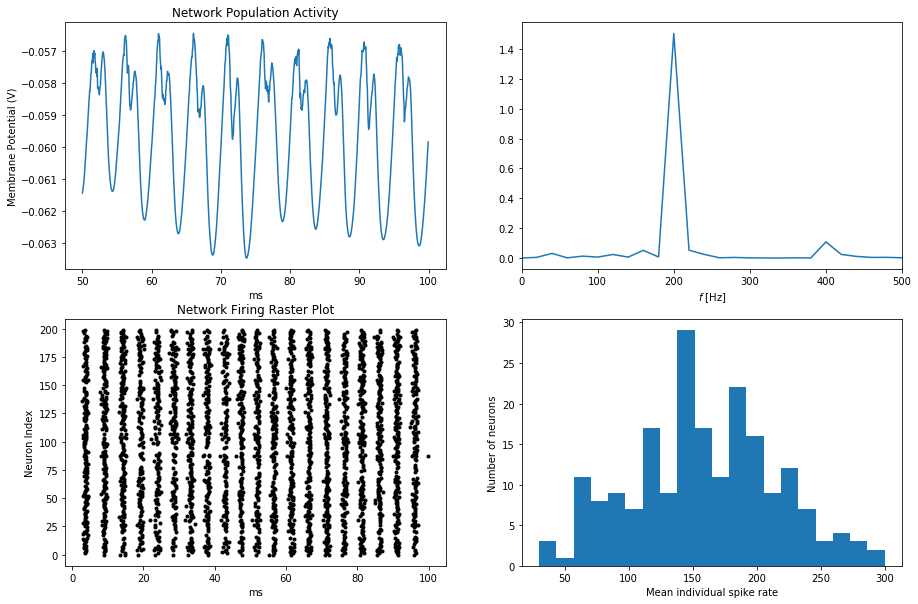

In [15]:
plot_all(T_7k, v_pop_7k, Rate_Mon_7k, Spike_Mon_7k, simulation_duration_7k)

In [16]:
## 8000 Hz
start_scope()
simulation_duration_8k = 100*ms
input_freqency_8k = 8000

State_Mon_8k, Spike_Mon_8k, Rate_Mon_8k = do_simulation(simulation_duration_8k, input_freqency_8k)

T_8k = State_Mon_8k.t[1000:]/ms
v_pop_8k = np.mean(State_Mon_8k.v , axis = 0)[1000:]     # population level average

Before v = -65. mV
After v = -57.45070485 mV


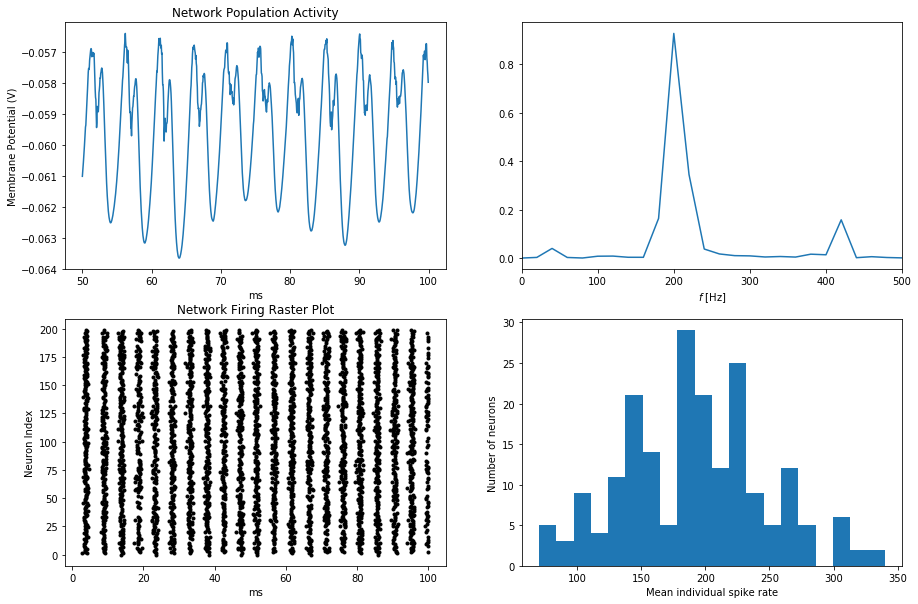

In [17]:
plot_all(T_8k, v_pop_8k, Rate_Mon_8k, Spike_Mon_8k, simulation_duration_8k)

In [18]:
## 10000 Hz
start_scope()
simulation_duration_10k = 100*ms
input_freqency_10k = 10000

State_Mon_10k, Spike_Mon_10k, Rate_Mon_10k = do_simulation(simulation_duration_10k, input_freqency_10k)

T_10k = State_Mon_10k.t[1000:]/ms
v_pop_10k = np.mean(State_Mon_10k.v , axis = 0)[1000:]     # population level average

Before v = -65. mV
After v = -56.76110481 mV


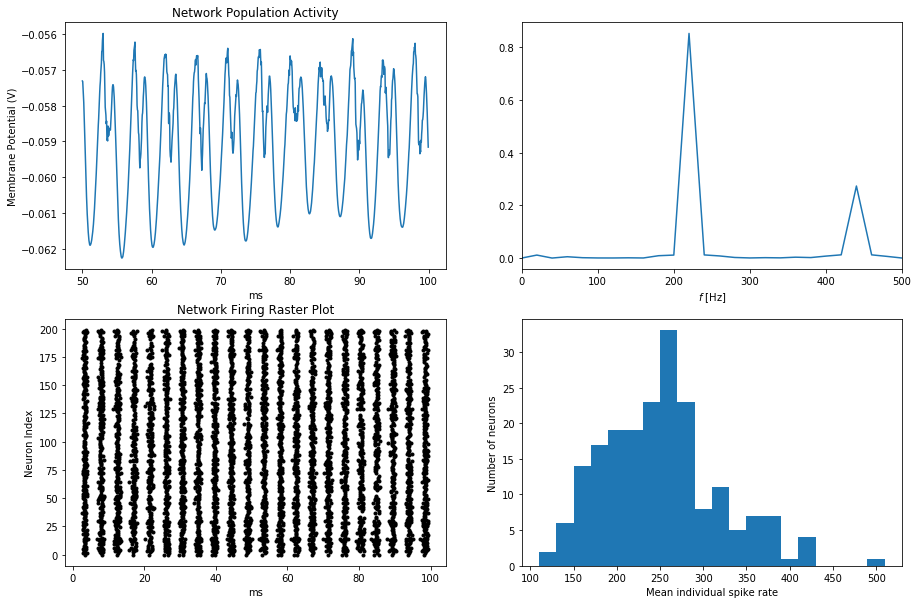

In [19]:
plot_all(T_10k, v_pop_10k, Rate_Mon_10k, Spike_Mon_10k, simulation_duration_10k)

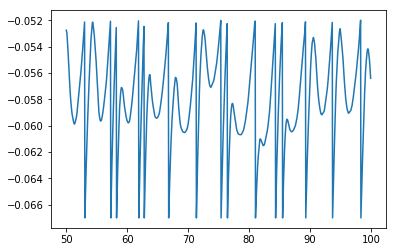

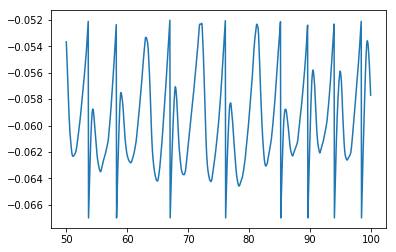

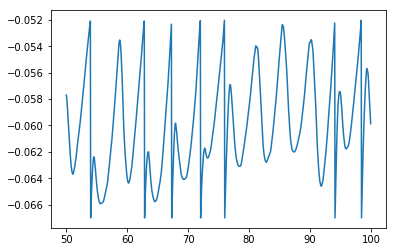

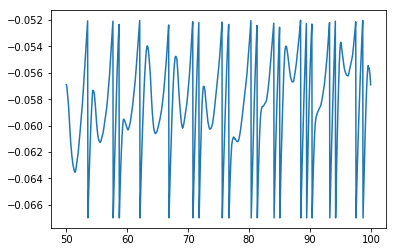

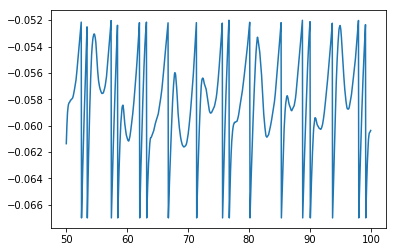

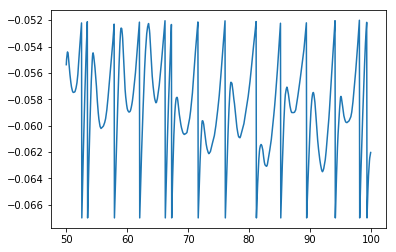

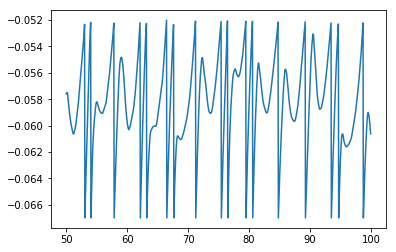

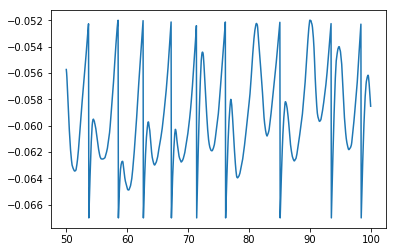

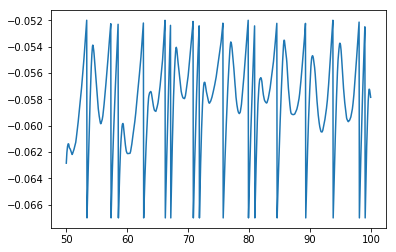

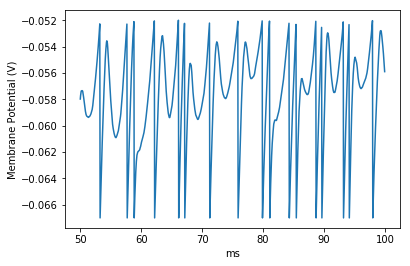

In [20]:
#plt.figure(figsize=(17,7))
for i in range(10):
    plt.figure()
    plot((State_Mon_10k.t[:]/ms)[1000:5000], (State_Mon_10k.v[i][:])[1000:5000])
xlabel('ms')
ylabel('Membrane Potential (V)')
plt.show()

In [35]:
## 15000 Hz
start_scope()
simulation_duration_15k = 100*ms
input_freqency_15k = 15000

State_Mon_15k, Spike_Mon_15k, Rate_Mon_15k = do_simulation(simulation_duration_15k, input_freqency_15k)

T_15k = State_Mon_15k.t[1000:]/ms
v_pop_15k = np.mean(State_Mon_15k.v , axis = 0)[1000:]     # population level average

Before v = -65. mV
After v = -60.35507206 mV


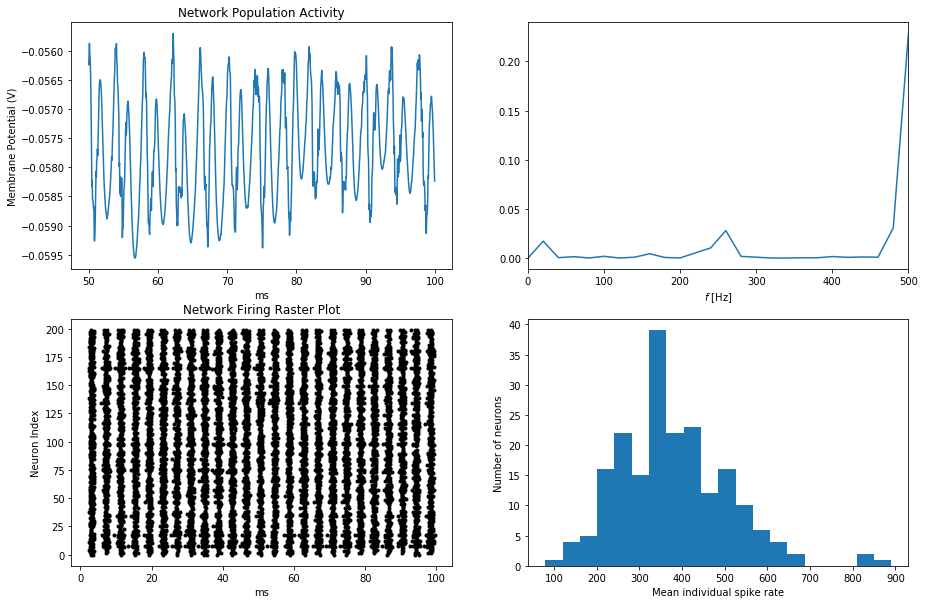

In [36]:
plot_all(T_15k, v_pop_15k, Rate_Mon_15k, Spike_Mon_15k, simulation_duration_15k)

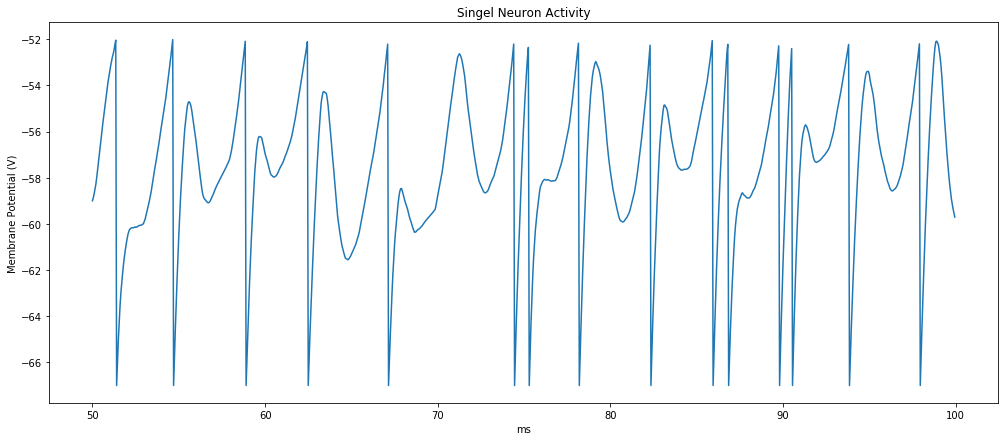

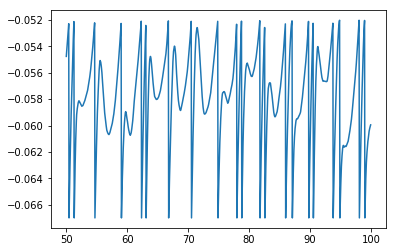

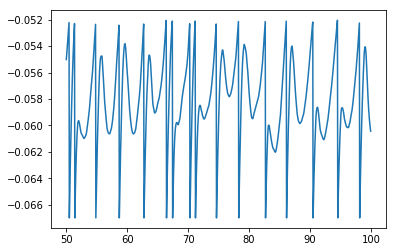

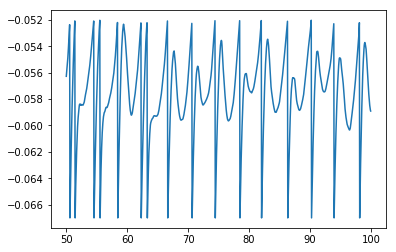

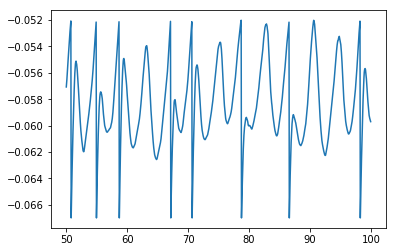

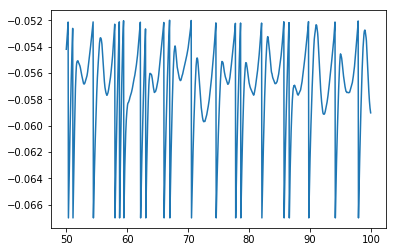

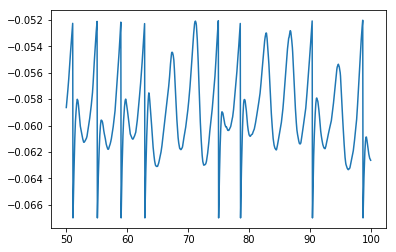

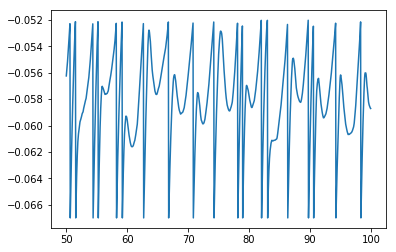

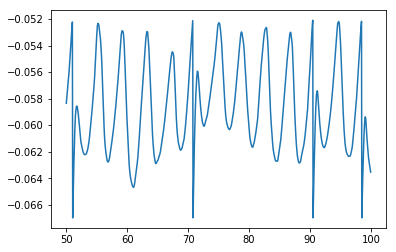

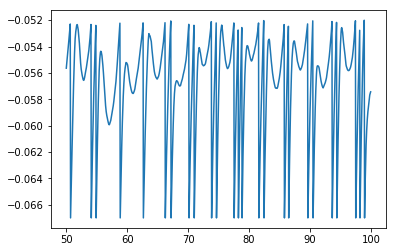

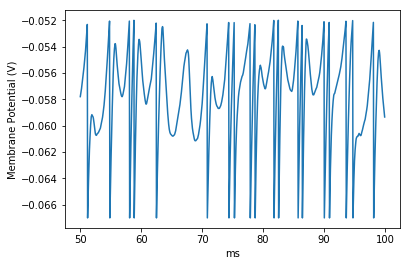

In [23]:
plt.figure(figsize=(17,7))
plot((State_Mon_15k.t[:]/ms)[1000:20000], (State_Mon_15k.v[np.random.randint(N_inhib)])[1000:20000]/mV)
xlabel('ms')
ylabel('Membrane Potential (V)')
plt.title('Singel Neuron Activity')
plt.show()

#plt.figure(figsize=(17,7))
for i in range(10):
    plt.figure()
    plot((State_Mon_15k.t[:]/ms)[1000:5000], (State_Mon_15k.v[np.random.randint(N_inhib)][:])[1000:5000])
xlabel('ms')
ylabel('Membrane Potential (V)')
plt.show()

In [24]:
def create_spec(Spike_Mon, sim_dur, win):
    # win in ms
    window = np.arange(0, sim_dur/ms, win)#*1e3#*ms
    
    #print("w:", window)
    times=Spike_Mon.t/ms
    #print("t:", times)
    
    spikes = np.zeros(len(window))
    for i in range(1,len(spikes)):
        spikes[i]=sum((times<window[i])*1-(times<window[i-1])*1)
        
    #print(spikes)

    plt.figure()
    plt.plot(spikes[2::])
    plt.figure()
    plt.specgram(spikes-np.mean(spikes),Fs=1000/win);


WARNING    c:\users\debap\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mlab.py:1246: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=100).
  "(=%d) >= signal length (=%d)." % (NFFT, len(x)))
 [py.warnings]


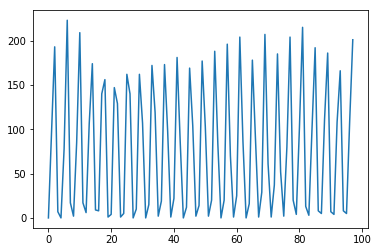

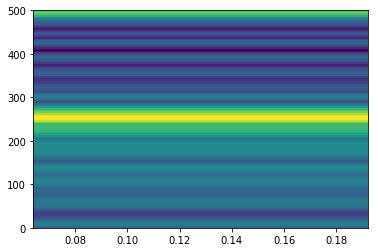

In [25]:
create_spec(Spike_Mon_15k, simulation_duration_15k, 1)

In [26]:
simulation_duration_15k

100. * msecond

In [27]:
## GABA 6000 Hz 
start_scope()
simulation_duration_G6k = 100*ms
input_freqency_G6k = 6000

State_Mon_G6k, Spike_Mon_G6k, Rate_Mon_G6k = do_simulation(simulation_duration_G6k, input_freqency_G6k, tau_d_i=2*1.2*ms, g_peak_i=2*5*nS)

T_G6k = State_Mon_G6k.t[1000:]/ms
v_pop_G6k = np.mean(State_Mon_G6k.v , axis = 0)[1000:]     # population level average

Before v = -65. mV
After v = -61.6100566 mV


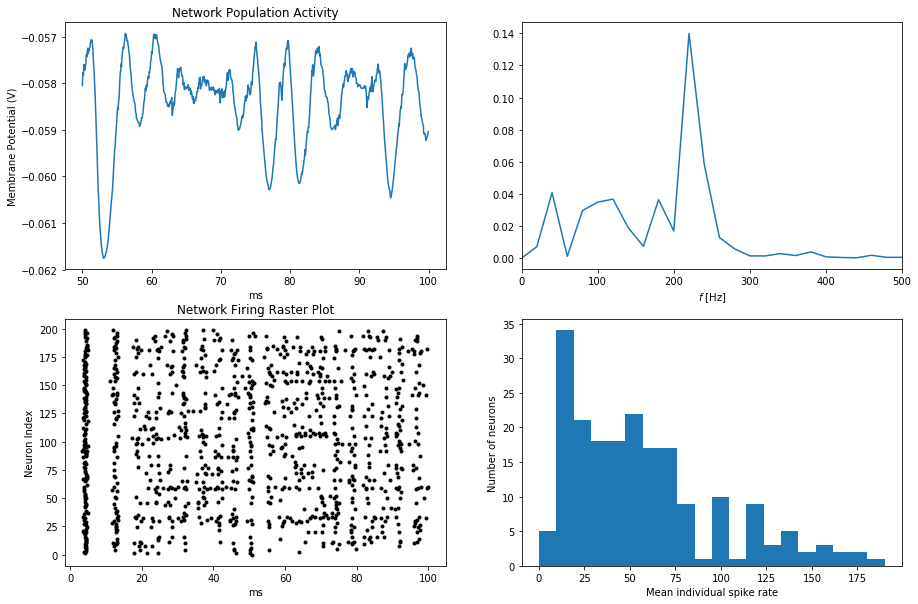

In [28]:
plot_all(T_G6k, v_pop_G6k, Rate_Mon_G6k, Spike_Mon_G6k, simulation_duration_G6k)

# sdvclnks
- less spikes, no 200Hz

In [84]:
## GABA 10000 Hz 
start_scope()
simulation_duration_G10k = 100*ms
input_freqency_G10k = 10000

State_Mon_G10k, Spike_Mon_G10k, Rate_Mon_G10k = do_simulation(simulation_duration_G10k, input_freqency_G12k, tau_d_i=2*1.2*ms, g_peak_i=2*5*nS)

T_G10k = State_Mon_G10k.t[1000:]/ms
v_pop_G10k = np.mean(State_Mon_G10k.v , axis = 0)[1000:]     # population level average

Before v = -65. mV
After v = -66.14710687 mV


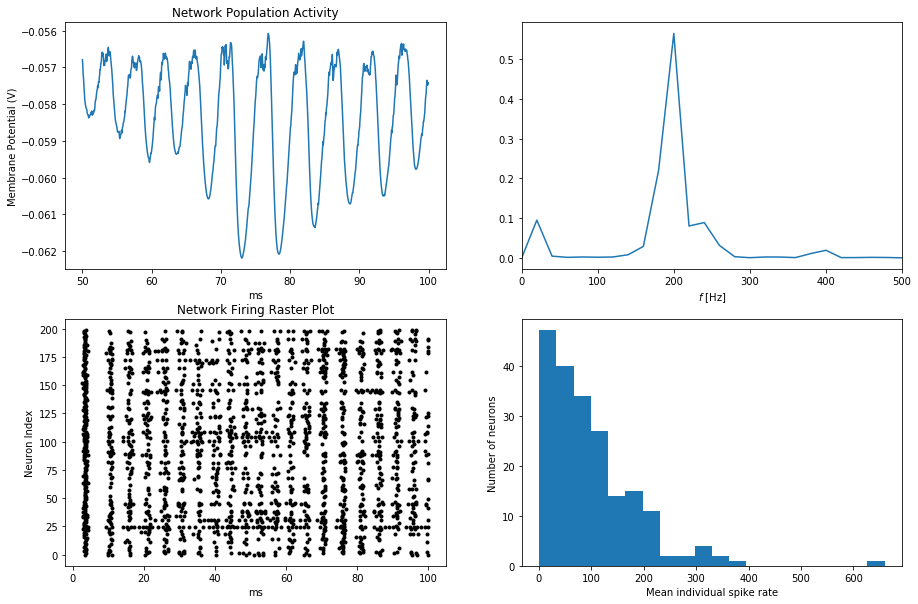

In [85]:
plot_all(T_G10k, v_pop_G10k, Rate_Mon_G10k, Spike_Mon_G10k, simulation_duration_G10k)

In [29]:
## GABA 12000 Hz 
start_scope()
simulation_duration_G12k = 100*ms
input_freqency_G12k = 12000

State_Mon_G12k, Spike_Mon_G12k, Rate_Mon_G12k = do_simulation(simulation_duration_G12k, input_freqency_G12k, tau_d_i=2*1.2*ms, g_peak_i=2*5*nS)

T_G12k = State_Mon_G12k.t[1000:]/ms
v_pop_G12k = np.mean(State_Mon_G12k.v , axis = 0)[1000:]     # population level average

Before v = -65. mV
After v = -55.5499931 mV


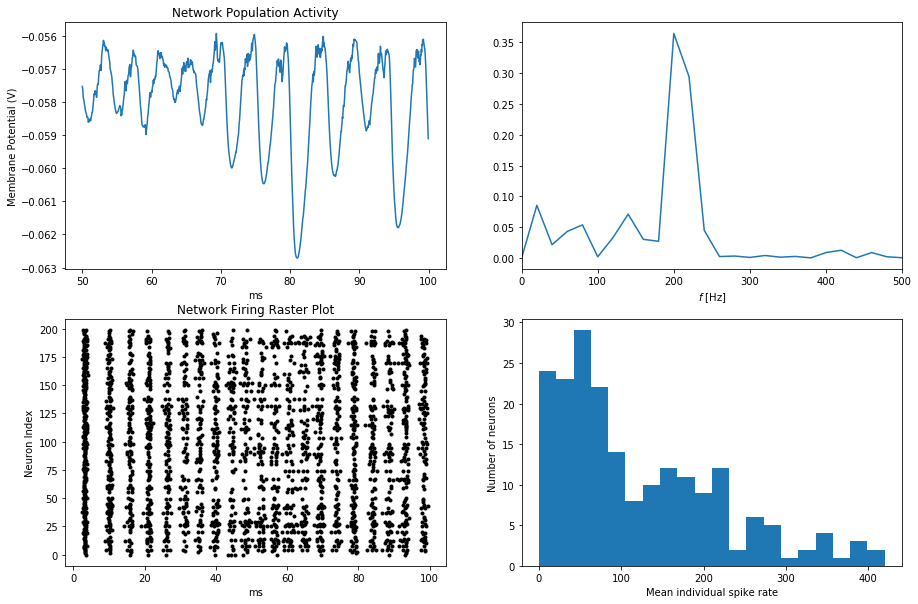

In [30]:
plot_all(T_G12k, v_pop_G12k, Rate_Mon_G12k, Spike_Mon_G12k, simulation_duration_G12k)

# smooth
# < 200 Hz
- less spikes

In [31]:
## GABA 15000 Hz 
start_scope()
simulation_duration_G15k = 100*ms
input_freqency_G15k = 15000

State_Mon_G15k, Spike_Mon_G15k, Rate_Mon_G15k = do_simulation(simulation_duration_G15k, input_freqency_G15k, tau_d_i=2*1.2*ms, g_peak_i=2*5*nS)

T_G15k = State_Mon_G15k.t[1000:]/ms
v_pop_G15k = np.mean(State_Mon_G15k.v , axis = 0)[1000:]     # population level average

Before v = -65. mV
After v = -60.03949664 mV


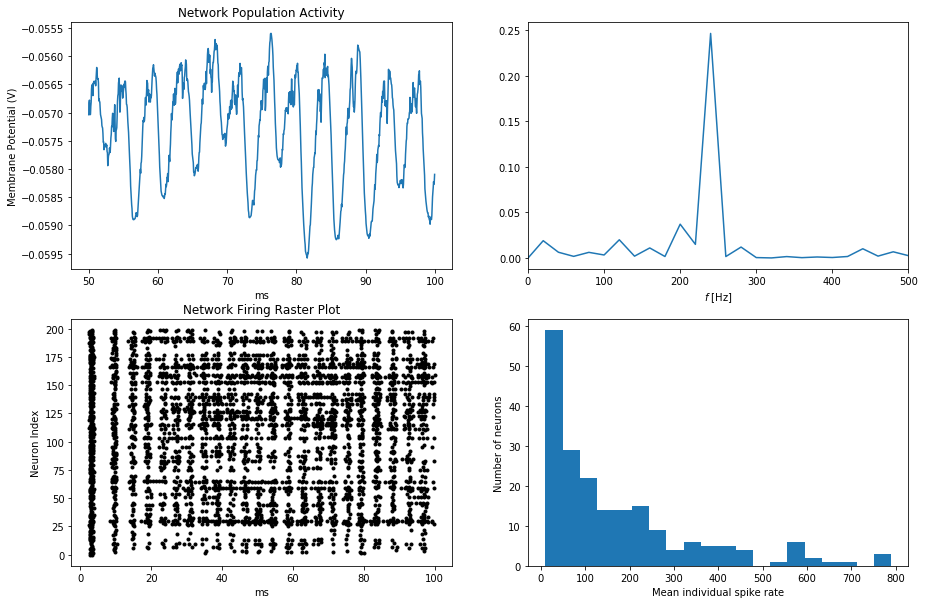

In [32]:
plot_all(T_G15k, v_pop_G15k, Rate_Mon_G15k, Spike_Mon_G15k, simulation_duration_G15k)

# Some remarks
  We actually observe that the 200 Hz oscillation peak does not shift in frequency (apart from when the input frequency is 15 kHz.) However, we note the significant decrease in the power of that frequency in the spectral energy distribution. (Isn't this the same kinda result from the paper??)

# Inter Spike Interval and Variability 

In [86]:
def isi_analysis(spike_mon):

    # Inter-Spike-Interval (ISI)

    spike_times = []
    isi_array   = []
    isi_means   = []
    isi_std     = []
    for j in range(200):
        spike_time_temp = spike_mon.t[np.where(spike_mon.i == j)[0]]/ms
        spike_times += [spike_time_temp]    

        # Calculate ISI while doing loop 

        if len(spike_time_temp) > 1:

            isi_array += [np.diff(spike_time_temp)]

            isi_means += [np.mean(np.diff(spike_time_temp))]
            isi_std += [np.std(np.diff(spike_time_temp))]
    
    return isi_array , isi_means , isi_std   

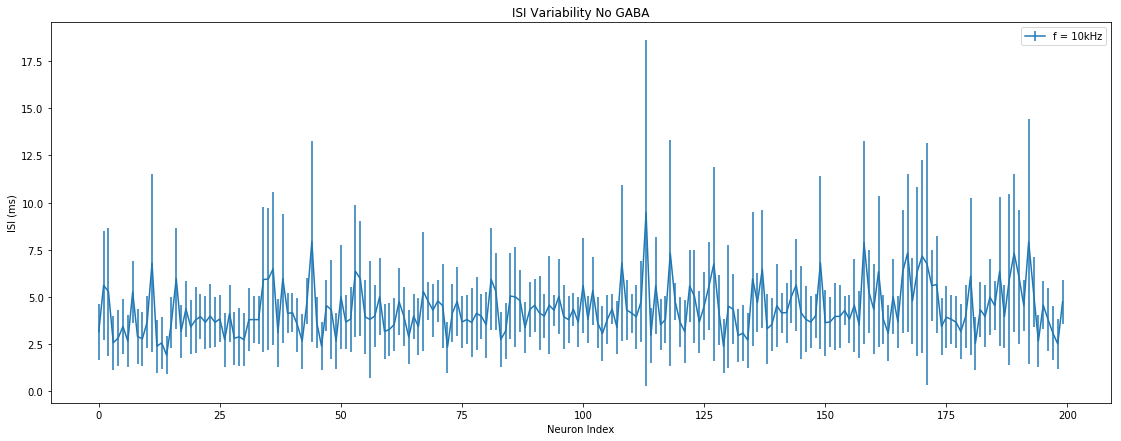

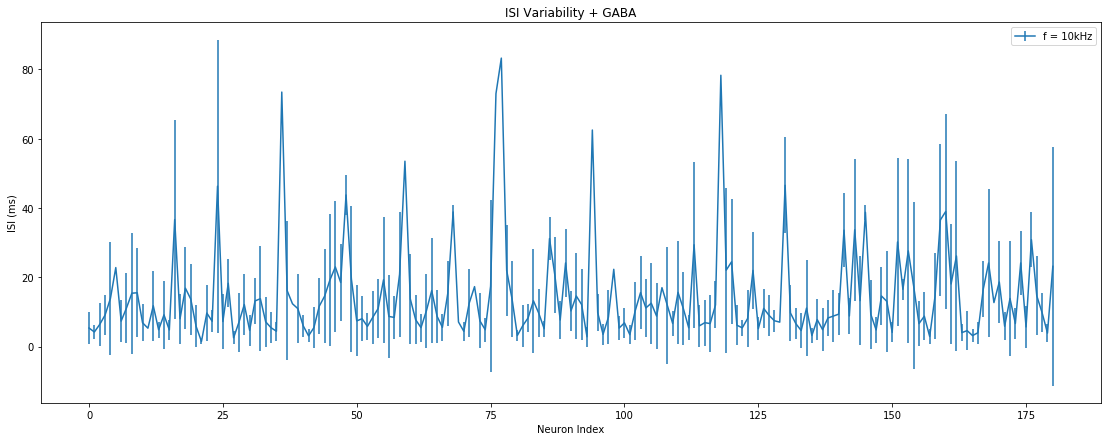

In [88]:
isi_array , isi_means , isi_std    = isi_analysis(Spike_Mon_10k)

plt.rcParams['figure.figsize'] = (19,7)
plt.errorbar(np.arange(len(isi_means)) , isi_means , yerr = isi_std, label = 'f = 10kHz')
plt.xlabel('Neuron Index')
plt.ylabel('ISI (ms)')
plt.title('ISI Variability No GABA' )
plt.legend()
plt.show()

isi_array , isi_means , isi_std    = isi_analysis(Spike_Mon_G10k)

plt.rcParams['figure.figsize'] = (19,7)
plt.errorbar(np.arange(len(isi_means)) , isi_means , yerr = isi_std , label = 'f = 10kHz')
plt.xlabel('Neuron Index')
plt.ylabel('ISI (ms)')
plt.legend()
plt.title('ISI Variability + GABA' )
plt.show()


# Some remarks
- From the ISI mean distribution, we definitely see a much more biologically and informationally relevant inter spike interval and also less variability in the ISIs. A mean ISI of ~ 5 ms could still imply tight coupling between neurons while ISIs on the order of 20 ms or so, with high standard deviation would more indicate random neuronal firings. This could be one of the metrics to characeterise the strength and type of the oscillation the network achieves. 